# PointNet

## Initialize directories

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r gdrive/MyDrive/VisionLab2_PointNet/* ./

In [ ]:
!wget https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!cp shapenetcore_partanno_segmentation_benchmark_v0.zip gdrive/MyDrive/VisionLab2_PointNet/
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip

!mv shapenetcore_partanno_segmentation_benchmark_v0 shapenet_data


In [ ]:
!pip install plyfile

## Imports

In [1]:
import sys
sys.path.insert(1, 'codes')

In [2]:
from __future__ import print_function
import argparse
import os
import random

import numpy as np
import torch
import torch.nn.parallel
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from dataset import ShapeNetDataset
from model import PointNetCls, feature_transform_regularizer, PointNetDenseCls
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=32, help='input batch size')
parser.add_argument('--num_points', type=int, default=2500, help='input batch size')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=0)
parser.add_argument('--model', type=str, default='', help='model path')
parser.add_argument('--nepoch', type=int, default=250, help='number of epochs to train for')
parser.add_argument('--outf', type=str, default='cls', help='output folder')
parser.add_argument('--dataset', type=str, required=False, help="dataset path", default="../shapenet_data/shapenetcore_partanno_segmentation_benchmark_v0")
parser.add_argument('--feature_transform', default='True', help="use feature transform")
parser.add_argument('--save_dir', default='pretrained_networks', help='directory to save model weights')

opt = parser.parse_args(args=[])
print(opt)

if not os.path.exists(opt.save_dir):
    os.makedirs(opt.save_dir, exist_ok=True)
try:
    os.makedirs(opt.outf, exist_ok=True)
except OSError:
    pass


opt.manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

Namespace(batchSize=32, dataset='../shapenet_data/shapenetcore_partanno_segmentation_benchmark_v0', feature_transform='True', model='', nepoch=250, num_points=2500, outf='cls', save_dir='pretrained_networks', workers=0)
Random Seed:  1207


## Dataloaders

### Classification

In [4]:
dataset = ShapeNetDataset(
    root=opt.dataset,
    classification=True,
    npoints=opt.num_points)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batchSize,
    shuffle=True,
    num_workers=int(opt.workers))

val_dataset = ShapeNetDataset(
    root=opt.dataset,
    classification=True,
    split='val',
    npoints=opt.num_points)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=opt.batchSize,
    shuffle=False,
    num_workers=int(opt.workers))

print(len(dataset))


{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
{'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
{'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4
12137


In [5]:
num_classes = len(dataset.classes)
print('classes', num_classes)
classifier = PointNetCls(num_classes=num_classes, feature_transform=opt.feature_transform)
path = "gdrive/MyDrive/VisionLab2_PointNet/pretrained_networks/classification_feat_trans_True.pt"
load = True

classes 16


### Segmentation

In [4]:
classchoice = 'Chair'

dataset = ShapeNetDataset(
    root=opt.dataset,
    classification=False,
    class_choice=[classchoice])

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batchSize,
    shuffle=True,
    num_workers=int(opt.workers))

val_dataset = ShapeNetDataset(
    root=opt.dataset,
    classification=False,
    class_choice=[classchoice],
    split='val', # TODO  <------------------------------- val or test????
    data_augmentation=False)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=opt.batchSize,
    shuffle=True,
    num_workers=int(opt.workers))

print(len(dataset))


{'Chair': 0}
{'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4
{'Chair': 0}
{'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4
2658


In [5]:
num_classes = dataset.num_seg_classes
print('classes', num_classes)
classifier = PointNetDenseCls(num_classes=num_classes, feature_transform=opt.feature_transform)
path = "pretrained_networks/segmentation_feat_trans_True.pt"
load = False

classes 4


In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5, verbose=False)

classifier = classifier.to(device)
best_acc = -1
epochs = 0

if load:
    # classifier.load_state_dict(torch.load(opt.model))
  # model.load_state_dict(torch.load(path))
  checkpoint = torch.load(path, map_location=device)
  classifier.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  best_acc = checkpoint['best_acc']
  if 'epoch' in checkpoint:
    epochs = checkpoint['epoch']
  print(f'Model loaded with best acc of {best_acc} and trained for {epochs} epochs')



In [7]:
num_batch = len(dataloader)
epoch_losses = []
epoch_accuracy = []
learning_rates = []

In [8]:
# train_epochs = opt.nepoch
train_epochs = 1

## Train

In [9]:
for epoch in range(epochs, epochs + opt.nepoch):
    classifier.train()
    epoch_loss = []
    pbar = tqdm(enumerate(dataloader), desc='Batches', leave=True)
    for i, data in pbar:
        points, target = data

        points = points.transpose(2, 1)
        points, target = points.to(device), target.to(device)
        scores, trans, trans_feat = classifier(points)
        if dataset.classification:
            target = target[:, 0]
        # perform forward and backward paths, optimize network
        loss = criterion(scores, target)
        loss = loss + \
            feature_transform_regularizer(
                trans) + feature_transform_regularizer(trans_feat)
        loss.backward()
        optimizer.step()
        tloss = loss.item()
        epoch_loss.append(tloss)
        pbar.set_description(f"loss: {tloss}")

        break  # TODO *********** remove

    epoch_losses.append(np.mean(epoch_loss))

    classifier.eval()
    shape_ious = []
    if dataset.classification:
        total_preds = []
        total_targets = []
    else:
        total_preds = np.zeros((0, dataset.npoints))
        total_targets = np.zeros((0, dataset.npoints))
    with torch.no_grad():
        pbar = tqdm(enumerate(val_dataloader, 0))
        for i, data in pbar:
            points, target = data
            points = points.transpose(2, 1)
            points, target = points.to(device), target.to(device)
            preds, _, _ = classifier(points)
            
            if dataset.classification:
                target = target[:, 0]
                pred_labels = torch.max(preds, dim=1)[1]
                total_preds = np.concatenate(
                    [total_preds, pred_labels.cpu().numpy()])
                total_targets = np.concatenate(
                    [total_targets, target.cpu().numpy()])
                a = 0
            else:
                pred_choice = preds.data.max(1)[1]
                pred_np = pred_choice.cpu().data.numpy()
                target_np = target.cpu().data.numpy()

                for shape_idx in range(target_np.shape[0]):
                    # np.unique(target_np[shape_idx])
                    parts = range(num_classes)
                    part_ious = []
                    for part in parts:
                        I = np.sum(np.logical_and(
                            pred_np[shape_idx] == part, target_np[shape_idx] == part))
                        U = np.sum(np.logical_or(
                            pred_np[shape_idx] == part, target_np[shape_idx] == part))
                        if U == 0:
                            iou = 1  # If the union of groundtruth and prediction points is empty, then count part IoU as 1
                        else:
                            iou = I / float(U)
                        part_ious.append(iou)
                    shape_ious.append(np.mean(part_ious))
            break #TODO *********** remove 

    if dataset.classification:
        matches = (total_targets == total_preds)
        accuracy = 100 * matches.sum() / matches.size
        print('{} Epoch - Accuracy = {:.2f}%'.format(epoch, accuracy))
    else:
        print("{} Epoch - mIOU for class {}: {:.4f}".format(epoch,
              classchoice, np.mean(shape_ious)))
        accuracy = np.mean(shape_ious)

    epoch_accuracy.append(accuracy)
    learning_rates.append(lr_scheduler.get_last_lr())
    lr_scheduler.step()
    accuracy = round(accuracy, 3)
    if accuracy > best_acc or best_acc < 0:
        best_acc = accuracy
        print(f"Saving new best model with best acc {best_acc}")
        # path = os.path.join(opt.save_dir, f'classification_feat_trans_{opt.feature_transform}.pt')
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, path)


loss: 1.3902931213378906: : 0it [00:05, ?it/s]
0it [00:22, ?it/s]


0 Epoch - mIOU for class Chair: 0.2493
Saving new best model with best acc 0.249


loss: 1.225263237953186: : 0it [00:05, ?it/s]
0it [00:00, ?it/s]


KeyboardInterrupt: 

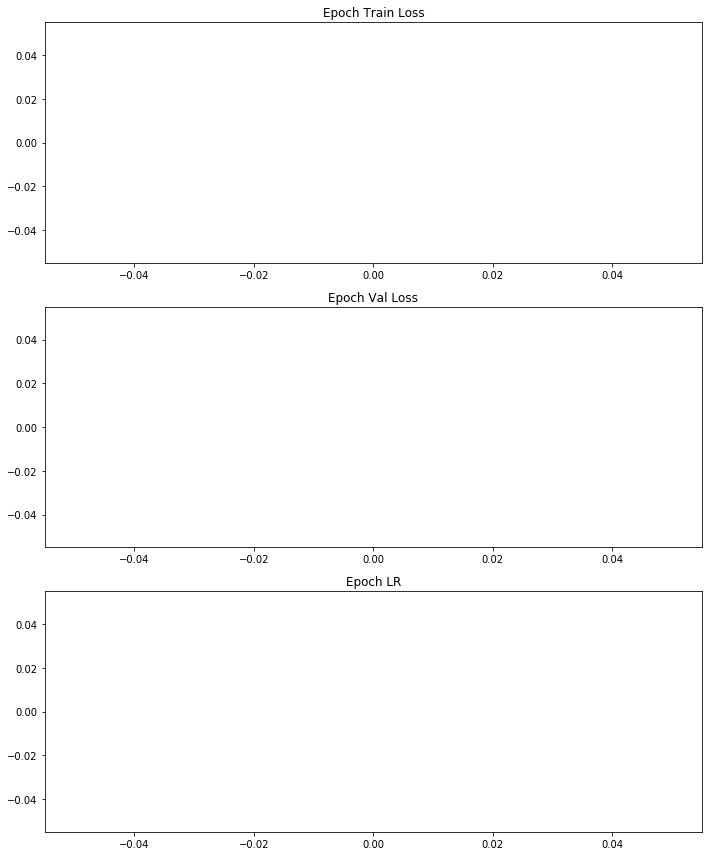

In [10]:
fig, ax = plt.subplots(3, figsize=(10, 12))
ax[0].plot(epoch_losses)
ax[0].set_title("Epoch Train Loss")
ax[1].plot(epoch_accuracy)
ax[1].set_title("Epoch Val Loss")
ax[2].plot(learning_rates)
ax[2].set_title("Epoch LR")
fig.tight_layout()